# Cyclical Learning Rates 

- toc: true

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
from fastai.vision.all import *
from fastbook import *

     |████████████████████████████████| 727kB 10.8MB/s 
     |████████████████████████████████| 194kB 50.8MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 1.1MB 57.2MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 92kB 11.9MB/s 
     |████████████████████████████████| 40kB 6.2MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 2.6MB 51.4MB/s 


In [49]:
#hide
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path

paths = [i for i in (path/'training').ls().sorted()]

paths_valid = [i for i in (path/'testing').ls().sorted()]

list_of_tensors = []
for label_path in paths:
  tempo = []
  for image in label_path.ls().sorted():
    tempo.append(tensor(Image.open(image)))
  
  list_of_tensors.append(torch.stack(tempo)) 

train_tensor = torch.cat(list_of_tensors)


list_of_tensors_valid = []
for label_path in paths_valid:
  tempo = []
  for image in label_path.ls().sorted():
    tempo.append(tensor(Image.open(image)))
  
  list_of_tensors_valid.append(torch.stack(tempo)) 

valid_tensor = torch.cat(list_of_tensors_valid)

valid_tensor = valid_tensor.view(-1, 28*28)

train_tensor = train_tensor.view(-1, 28*28)

tempo = []
for i in range(10):
  tempo.append([i] * len(paths_valid[i].ls()))
y_tensors = L(tempo).map(tensor)
y_tensors = torch.cat(list(y_tensors))

tempo = []
for i in range(10):
  tempo.append([i] * len(paths[i].ls()))
y_train = L(tempo).map(tensor)
y_train = torch.cat(list(y_train))

# Train dset
dset = list(zip(train_tensor.float() / 255, y_train))

# Valid dset
dset_valid = list(zip(valid_tensor.float() / 255, y_tensors))

dl = DataLoader(dset, batch_size=64, shuffle=True)
dl_valid = DataLoader(dset_valid, batch_size=64, shuffle=True)

## What is it ?

It's a technique introduced in this paper: [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186), written by Smith, Leslie N.

That suggests that rather then training a neural network with a fixed learning rate. It is more benefical to train it with a learning rate that cyclically vary between reasonable boundary values (even thought it may harm it during parts of the training, but overall it is more benfical).

> From now on we will call the cyclical learning rate policy as **CLR**.

## Why does it work ?

An intuitive understading of why **CLR** works is that when you consider your loss function, sometimes it will have plateaus when the gradient is really small, and that will slow the training process. So by variying the learning rate, you will pass those plateaus more rapidly (when the learning rate gets to the higher values).

## Definitions

The policy is desribed by the following image. 

![Triangular learning rate policy, image from the paper](../images/triang_policy.PNG)

We have four main things:

- Maximum bound (max_lr), the highest learning rate value. 
- Minimum bound (base_lr), the lowest learning rate value.
- Step size, the number of iterations that are needed to go from *base_lr* linearly to *max_lr*.
- Cycle is just 2 x Step, going from *min_lr* to *max_lr* then going back to *min_lr*.


## Implemetation

CLR comes in 3 variations, as described in the paper, however in this post we will implement one of them which is called **triangular** (the idea stays the same for the other two, but with somme subtleties).

We will implement it by training a simple *Neural Network* using the famous *MNIST* dataset.

As mentioned by the author, the accuracy results are quite robust to cycle lengths. So in our case we will just use step size = 2 * number of iterations per epoch.

Now the number of iterations per epoch is just :

In [3]:
# hide
total_num_of_items = len(get_image_files(path.ls()[0]))
batch_size = 64

In [4]:
number_iterations_per_epoch = np.floor(total_num_of_items / batch_size).astype('int') + 1
number_iterations_per_epoch

938

In [5]:
step_size = number_iterations_per_epoch * 2
step_size

1876

We'll set the requirements for training (i.e. a loss, the model, and gradient step)

In [6]:
# Create cross entropy loss function
loss_func = nn.CrossEntropyLoss()

In [8]:
def one_iteration():
  # set the optimizer that will do the gradient step for us
  opt = SGD(simple_net_CLR.parameters(), current_lr)

  # Get the activations
  preds = simple_net_CLR(xb)

  # Calculate the loss
  loss = loss_func(preds, yb)

  # Calculate the gradient
  loss.backward()

  # Do the step and set the gradient to zero
  opt.step()
  opt.zero_grad()

## Choose the boundaries

Now something that is really interesting in the paper, is that the author gives us a quite efficient ways of choosing our *base_lr* and *max_lr*. Which he calls **“LR range test”**.

The idea is to train our model for a few epochs while increasing the learning rate linearly from a small value to a big value. 

Then plot the accuracy according to the learning rate. 

Note the learning rate when the accuracy starts improving, and when the accuracy slows, becomes ragged or starts to fall. And set the first as your *base_lr* and the latter as your *max_lr*.

In [105]:
# Create the NN with 2 linear layers and one non linearity (Relu) between them
simple_net_CLR = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
)

In [53]:
# Set the starting learning rate and the final one
start_lr = 0.0001
final_lr = 1

# Create a numpy array with 314 values evenly spaced out from start_lr to final_lr
lr_range = np.linspace(start_lr, final_lr, 314)

# Get our batches of items
batches = list(dl)

# List where we will store the accuracy after each batch
batch_acc_v = []

# 314 is just an arbitrary number you can choose whatever works for you
for i in range(314):

  # Get the batch
  xb, yb = batches[i]

  # Set the learning rate
  current_lr = lr_range[i].item()

  # Do the iteration with the given learning rate
  one_iteration()

  # Calculate the accuracy and save it in the previously created list
  ba = tensor([accuracy(simple_net_CLR(xb), yb) for xb, yb in dl_valid]).mean().item()
  batch_acc_v.append(ba)

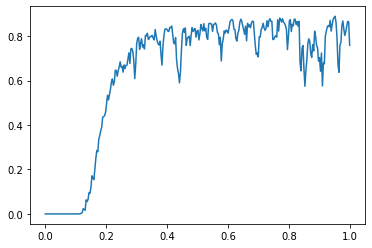

In [54]:
# Plot the accuracy according to learning rate
plt.plot(lr_range, batch_acc_v);

From the graph, we can reasonably choose base_lr = 0.175, max_lr = 0.25

But before we train our model with **CLR**, we'll train another model with a fixed learning rate so we have a baseline to compare to. We'll set the learning rate to 0.2 as it looks like a reasonable choice.


In [104]:
# Create base line NN with the same architechture as the previous one
base_line_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
)

In [65]:
#hide
def one_iteration_base():
  opt = SGD(base_line_net.parameters(), lr)
  preds = base_line_net(xb)
  loss = loss_func(preds, yb)
  loss.backward()
  opt.step()
  opt.zero_grad()

In [ ]:
# Setting the learning rate
lr = 0.2

# List to store the accuracy after each epoch
batch_acc_v = []

# Training for 30 epochs
for i in range(30):
  for xb, yb in dl:

    # do one gradient step 
    one_iteration_base()
  
  # Calculate accuracy after each epoch
  ba = tensor([accuracy(base_line_net(xb), yb) for xb, yb in dl_valid]).mean().item()
  batch_acc_v.append(ba)

In [110]:
print('Best accuracy: ', max(batch_acc_v))

Best accuracy:  0.9675557613372803


Now that we have everything we need, let's train the model and see the results.

In [106]:
# Set the learning rates
base_lr = 0.175
max_lr = 0.25
current_lr = base_lr

# Set the values of the learning rates for each part of the cycle
values_of_lr_as = np.linspace(base_lr, max_lr, step_size)
values_of_lr_ds = np.linspace(max_lr, base_lr, step_size)

# To know if we are in the first part of the cycle or the second (ascending / descending)
smaller_values = True

# when iter == stepsize we will change from ascending to descending ad vice versa
iter = 0

epochs = 30
batch_acc_v = []

for i in range(epochs):
  
  for xb, yb in  dl:
    # one iteration

    # take gradient step
    one_iteration()

    # increment bacause we did one iteration
    iter += 1

    # if yes change from descending to ascending and vice versa
    if iter == step_size :
      if smaller_values: 
        smaller_values = False
        iter = 1
      else: 
        smaller_values = True
        iter = 1

    if smaller_values:
      current_lr = values_of_lr_as[iter].item()
    else:
      current_lr = values_of_lr_ds[iter].item()

  # Calculate the accuracy after each epoch
  ba = tensor([accuracy(simple_net_CLR(xb), yb) for xb, yb in dl_valid]).mean().item()
  batch_acc_v.append(ba)

In [109]:
print('Best accuracy: ', max(batch_acc_v))

Best accuracy:  0.9710389971733093


The **CLR** is a clear winner, as it achieved 97.10 % accuracy as opposed to 96.75 % for the fixed learning rate policy.

> The author also suggests to stop the training at the end of the cycle as it is the moment where the learning rate gets to the lower values.